In [ ]:
# Import necessary TensorFlow and Keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import pandas for data manipulation and warnings to handle warning messages
import pandas as pd
import warnings

# Import PIL for working with images, NumPy for numerical operations, and scikit-learn for data splitting
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Import Keras callbacks for early stopping, model checkpoint, and learning rate scheduling
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Import OS for operating system-related functionality and ImageDataGenerator for image preprocessing
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

# Filter out specific warning messages (e.g., DeprecationWarnings)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Import necessary libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping


# Mount Google Drive in a Colab environment
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
train_dataset = pd.read_csv('/content/drive/My Drive/archive/sign_data/train_data.csv')
test_dataset = pd.read_csv('/content/drive/My Drive/archive/sign_data/test_data.csv')

train_dir = '/content/drive/My Drive/archive/sign_data/train'
test_dir = '/content/drive/My Drive/archive/sign_data/test'



In [ ]:
# Function for data preprocessing
def preprocess_image(image_path, target_size=(64, 64)):
    # Open image, resize, and convert to NumPy array while normalizing pixel values
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = img_to_array(img)
    img_array = img_array.astype(np.float32) / 255.0  # Normalize pixel values
    return img_array

# Function for generating batches of data
def datagen(dataset, batch_size, dir):
    num_samples = len(dataset)
    while True:
        # Shuffling the samples
        dataset = dataset.sample(frac=1)
        for batch in range(0, num_samples, batch_size):
            # Get batch samples for image1, image2, and labels
            image1_batch_samples = dataset.iloc[:, 0][batch:batch + batch_size]
            image2_batch_samples = dataset.iloc[:, 1][batch:batch + batch_size]
            label_batch_samples = dataset.iloc[:, 2][batch:batch + batch_size]
            Image1, Image2, Label = [], [], []
            for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                # Append preprocessed images and labels to lists
                image1_data = preprocess_image(os.path.join(dir, image1))
                image2_data = preprocess_image(os.path.join(dir, image2))
                Image1.append(image1_data)
                Image2.append(image2_data)
                Label.append(label)
            # Convert lists to NumPy arrays
            Image1 = np.asarray(Image1)
            Image2 = np.asarray(Image2)
            Label = np.asarray(Label).astype(np.float32)
            yield [Image1, Image2], Label

train_set, val_set = train_test_split(train_dataset, test_size=0.25, random_state=42)

# Creating DataLoader instances for train and val sets
#The DataLoader is a mechanism for efficiently loading and iterating over batches of data during the training process.
batch_size = 16  # You can adjust this based on your requirements
train_gen = datagen(train_set, batch_size, train_dir)
val_gen = datagen(val_set, batch_size, train_dir)

# Define siamese model(for image similarity) architecture
def custom_siamese_model(input_shape):
    input1 = Input(input_shape)
    input2 = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    embedding1 = model(input1)
    embedding2 = model(input2)

    # Calculate Manhattan distance
    #Manhattan distance is a common choice for measuring the dissimilarity between the embedded representations of two input samples.
    loss_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    manhattan_distance = loss_layer([embedding1, embedding2])
    output = Dense(1, activation='sigmoid')(manhattan_distance)

    network = Model(inputs=[input1, input2], outputs=output)
    return network

# Instantiate early stopper with custom callbacks
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1)
custom_callback = [early_stopper]

# Instantiate model
model = custom_siamese_model((64, 64, 3))
model.summary()

# Compile the model
optimizer = Adam(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

# Training the model for 5 epochs
print("Initializing Training !!")
num_train_samples = len(train_set)
num_val_samples = len(val_set)

history = model.fit(
    train_gen,
    verbose=1,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=5,
    validation_data=val_gen,
    validation_steps=num_val_samples // batch_size,
    callbacks=custom_callback
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          7873664     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 256)          0           ['sequential[0][0]',         

Initializing Training !!
Epoch 1/5
1087/1087 [==============================] - 1065s 978ms/step - loss: 0.1544 - accuracy: 0.9447 - val_loss: 0.0397 - val_accuracy: 0.9934
Epoch 2/5
1087/1087 [==============================] - 660s 607ms/step - loss: 0.0236 - accuracy: 0.9970 - val_loss: 0.0389 - val_accuracy: 0.9929
Epoch 3/5
1087/1087 [==============================] - 631s 581ms/step - loss: 0.0196 - accuracy: 0.9968 - val_loss: 0.0487 - val_accuracy: 0.9938
Epoch 4/5
1087/1087 [==============================] - 615s 566ms/step - loss: 0.0262 - accuracy: 0.9965 - val_loss: 0.0148 - val_accuracy: 0.9972
Epoch 5/5
1087/1087 [==============================] - 651s 599ms/step - loss: 0.0104 - accuracy: 0.9989 - val_loss: 0.0130 - val_accuracy: 0.9971


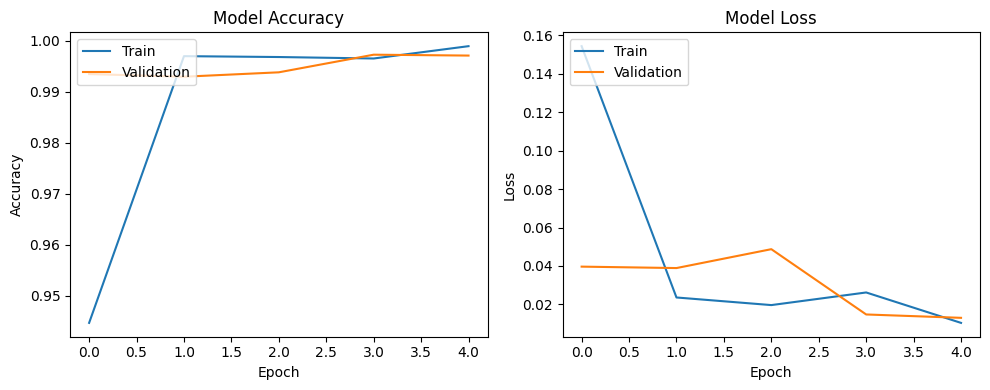

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Create DataLoader instances for test set
test_gen = datagen(test_dataset, batch_size, test_dir)

# Evaluate the model on the test set
num_test_samples = len(test_dataset)
test_accuracy = model.evaluate(test_gen, steps=num_test_samples // batch_size)

print("Test Accuracy:", test_accuracy)


359/359 [==============================] - 215s 600ms/step - loss: 0.0144 - accuracy: 0.9979
Test Accuracy: [0.01435675285756588, 0.9979108572006226]


1/1 [==============================] - 0s 219ms/step
Similarity Score: 0.9937795


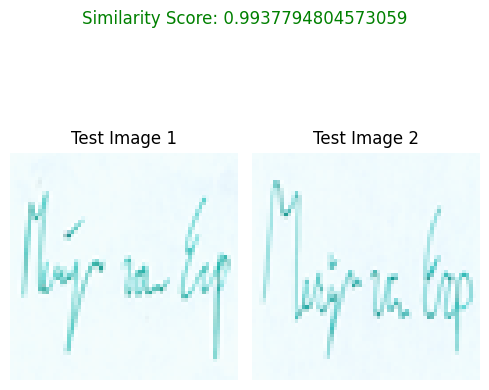

In [ ]:
def preprocess_test_image(image_path, target_size=(64, 64)):
    # Open and resize the test image
    img = Image.open(image_path)
    img = img.resize(target_size)

    # Convert the image to a NumPy array and add an extra dimension
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize pixel values to the range [0, 1]
    img_array = img_array.astype('float32') / 255.0

    return img_array

# Define the paths to the test images
test_image1_path = '/content/drive/My Drive/archive/sign_data/F.png'
test_image2_path = '/content/drive/My Drive/archive/sign_data/R.png'

# Load and preprocess the test images
test_image1 = preprocess_test_image(test_image1_path)
test_image2 = preprocess_test_image(test_image2_path)

# Perform inference on the test images
prediction = model.predict([test_image1, test_image2])

# Print the similarity score
similarity_score = prediction[0][0]
print('Similarity Score:', similarity_score)

# Display the test images with the similarity score as legend
plt.figure(figsize=(5, 5))

# Display the first test image
plt.subplot(1, 2, 1)
plt.imshow(test_image1[0])
plt.title('Test Image 1')
plt.axis('off')

# Display the second test image
plt.subplot(1, 2, 2)
plt.imshow(test_image2[0])
plt.title('Test Image 2')
plt.axis('off')

# Display the similarity score as the figure title, color-coded
plt.suptitle(f'Similarity Score: {similarity_score}', fontsize=12, color='green' if similarity_score > 0.5 else 'red')
plt.tight_layout()
plt.show()
